# Unsupervised Classification

## Load imports.

In [1]:
# Make common scripts visible and unsupervised classifier code
import sys
sys.path.append('../common/')
sys.path.append('../kb-classifier/')

import numpy as np
import nltk
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from reuters_parser import load_data
from lookup_tables import topic_code_to_topic_dict, topic_code_to_int, int_to_topic_code
from sentence_utils import remove_stop_words_and_lemmatize
from conversion import convert_dictionary_to_array
from kb_classifier import KnowledgeBasePredictor
from kb_common import int_to_topic

## Load the data.

In [2]:
def sanitise_each_topic(text):      
    return remove_stop_words_and_lemmatize(text, lowercase=False, lemmatize=False, keep_nouns_only=True)


year_data = load_data('19960820', '19970819', '../../../downloads/reuters/rcv1/', topic_code_to_topic_dict)
#year_data = load_data('19960820', '19960830', '../../../downloads/reuters/rcv1/', topic_code_to_topic_dict)

# For accurate comparison with the Naive Bayes classifier, keep the last 20% of documents using the same random seed.
# I.e. we are making predictions on the same test set.
np.random.seed(42)

# Get 20% test
x, y = convert_dictionary_to_array(year_data, topic_code_to_int)
total_examples = len(y)
split_point = int(total_examples * 0.8)
test_x = np.array(list(map(sanitise_each_topic, x[split_point:])))
test_y = y[split_point:]


# Take 20 documents of each type from the training set for classifier tuning
train_x = []
train_y = np.zeros(shape=7200)

counts = np.zeros(shape=len(topic_code_to_int.keys()))
current_index = 0
print(split_point)
for i in range(split_point):
    topic_int = y[i]
    
    if counts[topic_int] < 1200:
        train_x.append(x[i])
        train_y[current_index] = topic_int
        counts[topic_int] += 1
        current_index += 1

train_x = np.array(list(map(sanitise_each_topic, train_x)))
print(counts)

73723
[1200. 1200. 1200. 1200. 1200. 1200.]


## Initialise and tune class probabilities for unsupervised learner

In [3]:
np.random.seed(42)
kb_predictor = KnowledgeBasePredictor(topic_code_to_topic_dict.values(), topic_depth=2)
kb_predictor.train(train_x, train_y)

Wiki topic probabilies shape: (7200, 2555)


In [4]:
predict_y = kb_predictor.predict(train_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(train_y, predict_y)

print(classification_report)
print(confusion_matrix)

Wiki topic probabilies shape: (120, 2326)
                        precision    recall  f1-score   support

CRIME, LAW ENFORCEMENT   1.000000  1.000000  1.000000        20
  ECONOMIC PERFORMANCE   1.000000  1.000000  1.000000        20
             ELECTIONS   1.000000  1.000000  1.000000        20
                HEALTH   1.000000  1.000000  1.000000        20
              RELIGION   1.000000  1.000000  1.000000        20
                SPORTS   1.000000  1.000000  1.000000        20

             micro avg   1.000000  1.000000  1.000000       120
             macro avg   1.000000  1.000000  1.000000       120
          weighted avg   1.000000  1.000000  1.000000       120

[[20  0  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0  0 20  0  0]
 [ 0  0  0  0 20  0]
 [ 0  0  0  0  0 20]]


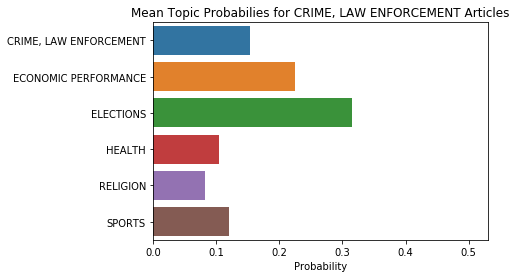

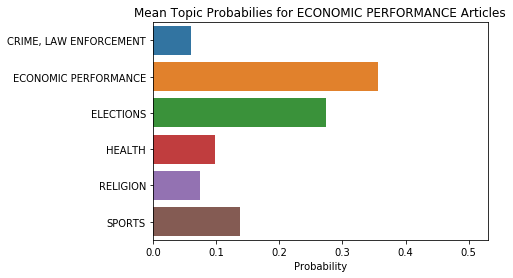

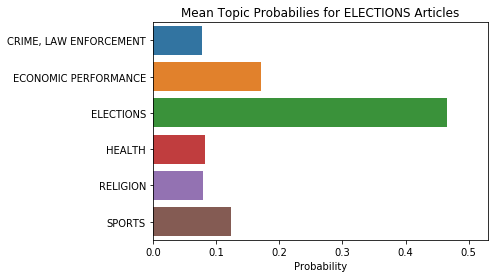

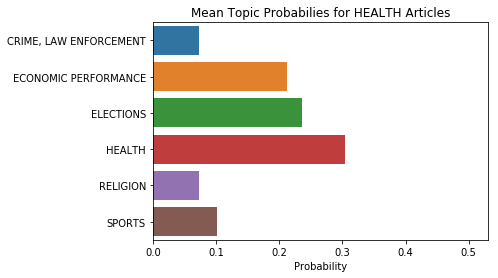

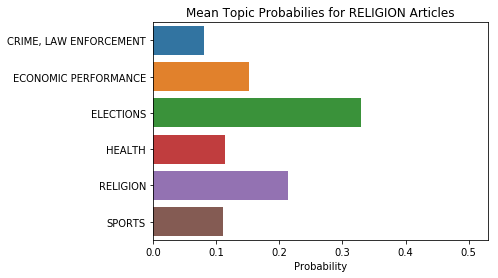

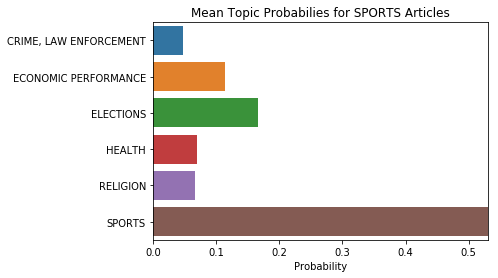

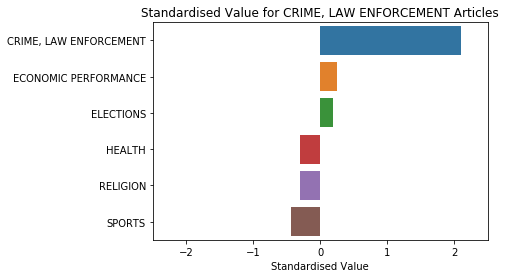

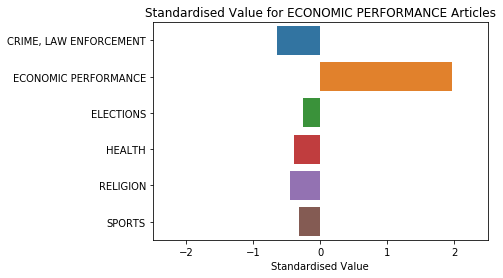

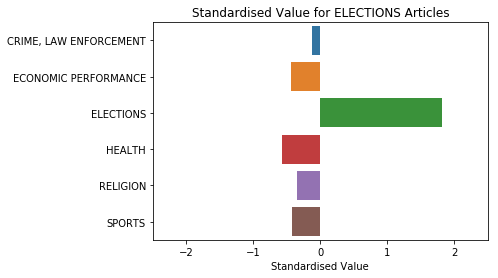

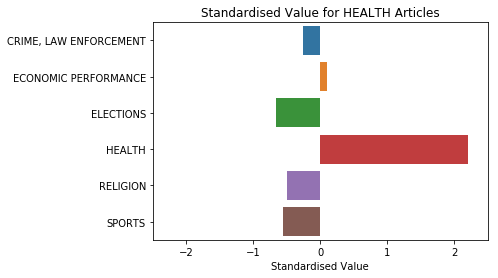

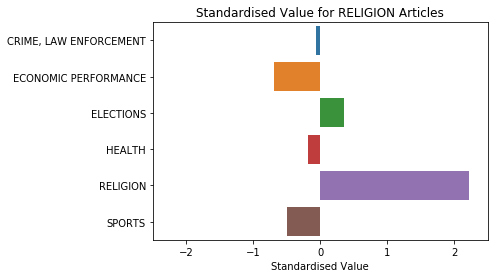

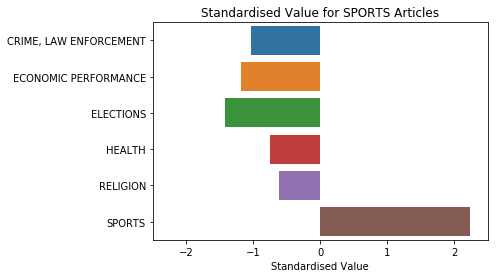

In [ ]:
prob_means = np.zeros(shape=(6, 6))

# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_means[index] = prob_mean
    
    plt.figure()
    plt.title('Mean Topic Probabilies for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Probability')
    plt.xlim(0.0, 0.53)
    sns.barplot(x=prob_mean, y=list(int_to_topic.values()))
    plt.savefig('topic_prob_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()
    
# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    
    plt.figure()
    plt.title('Standardised Value for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Standardised Value')
    plt.xlim(-2.5, 2.5)
    sns.barplot(x=((prob_mean-np.mean(prob_means, axis=0))/np.std(prob_means, axis=0)),
                   y=list(int_to_topic.values()))
    plt.savefig('standardised_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()

## Assess unsupervised classifier performance.

In [ ]:
print('Making predictions for {} documents'.format(len(test_y)))
predict_y = kb_predictor.predict(test_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(test_y, predict_y)

print(classification_report)
print(confusion_matrix)

Making predictions for 18431 documents


## Find examples where predictions went wrong

In [7]:
for topic_code, index in topic_code_to_int.items():
    topic_subset = predict_y[test_y == index]
    topic_subset_incorrect = topic_subset[topic_subset != index]
    document_subset = test_x[test_y == index]
    document_subset = document_subset[topic_subset != index]
    
    print('------ 5 random erroneous predictions for {} ------'.format(topic_code_to_topic_dict[topic_code]))
    print('')
    random_indices = np.random.choice(np.arange(len(topic_subset_incorrect)), 5)
    for index in random_indices:
        print(document_subset[index])
        print('')
        print('Above classified as {}'.format(topic_code_to_topic_dict[int_to_topic_code[topic_subset_incorrect[index]]]))
        print('')
    print('')

------ 5 random erroneous predictions for CRIME, LAW ENFORCEMENT ------

lawyer ousted Indonesian_Democratic_Party PDI leader Megawati_Sukarnoputri Tuesday talks out-of-court settlement government political rivals Wednesday R.O Tambunan Reuters lawyers parties Tuesday night discussions Wednesday suit Megawati government officials PDI rivals due Central_Jakarta_District_Court Thursday talks

Above classified as ELECTIONS

Labour Minister_Tito_Mboweni wide-ranging inquiry South_Africa violence-plagued mining industry Tuesday miner gold mine southwest Johannesburg Mine management state radio 33-year-old worker death fight East_Driefontein division Driefontein_Consolidated_Ltd reason flare-up violence miners scores recent weeks fights mines Gold_Fields South_Africa_Ltd violence output affected gold mines East_Driefontein platinum operation Gold Fields violence clashes 350,000-strong National_Union Mineworkers NUM Xhosa membership United_Workers Union South_Africa Zulu-led Inkatha_Freedom_P